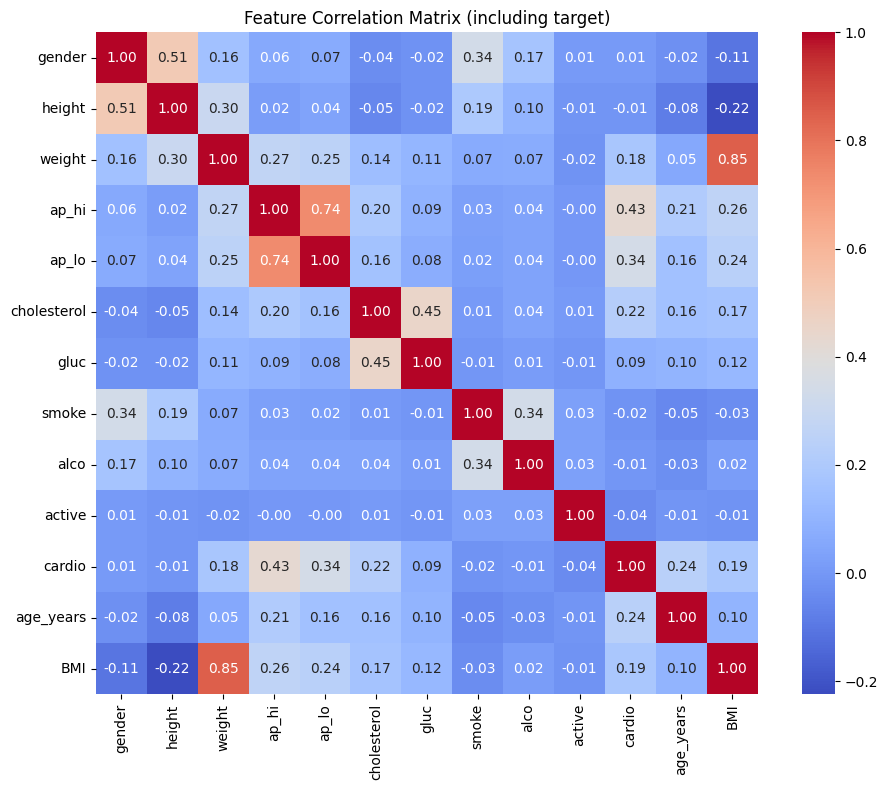

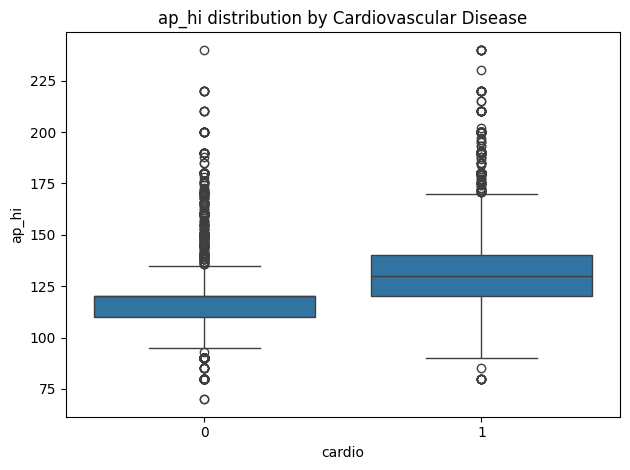

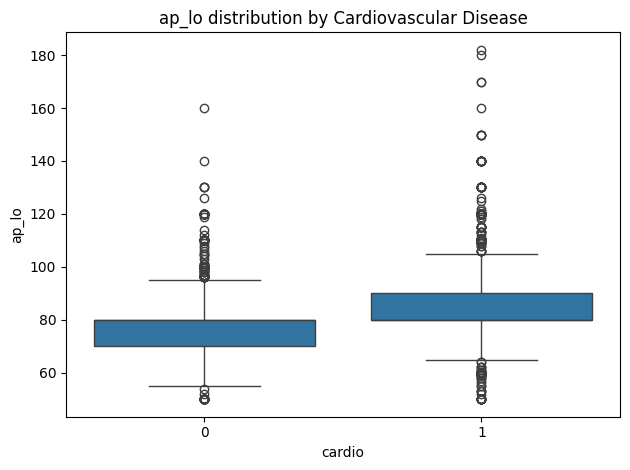

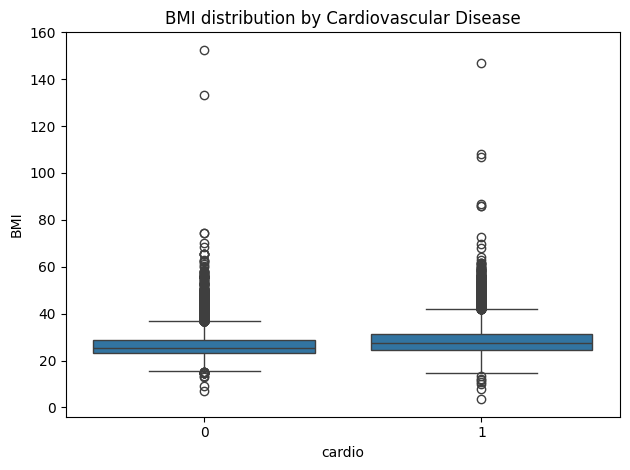

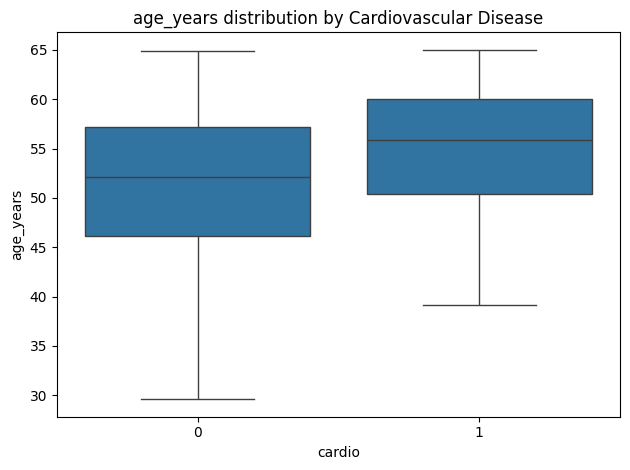

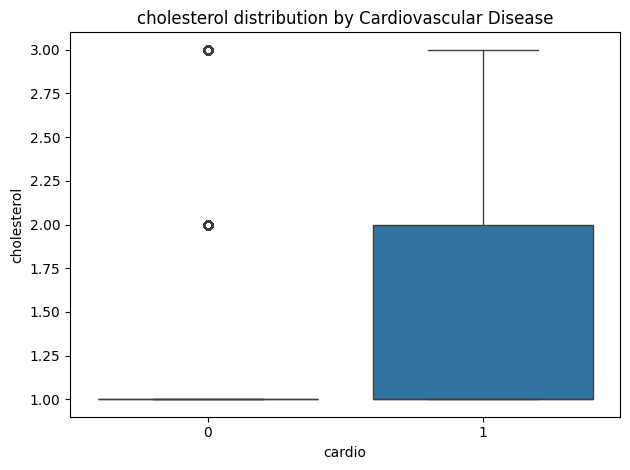

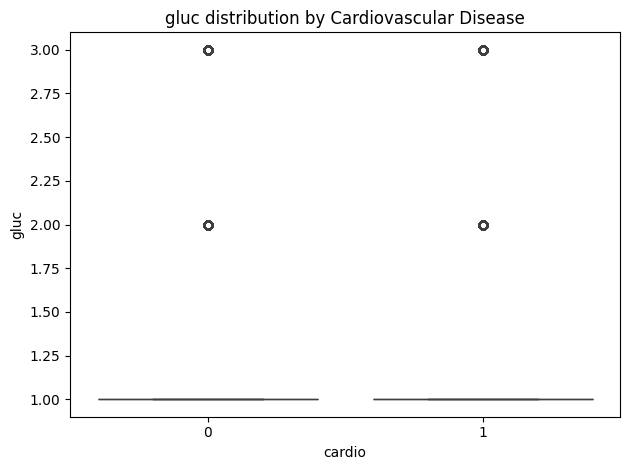

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay
)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

# 1. Load
df = pd.read_csv("/content/cardio_train (1).csv", sep=';')  # adjust path if needed

# 2. Preprocessing
# Convert age to years
df['age_years'] = (df['age'] / 365).round(1)

# Filter unrealistic values (common cleaning step from public kernels)
df = df[
    df['height'].between(100, 220) &
    df['weight'].between(10, 300) &
    df['ap_hi'].between(70, 250) &
    df['ap_lo'].between(50, 200)
].copy()

# Swap blood pressure if ap_lo > ap_hi
mask_swap = df['ap_lo'] > df['ap_hi']
df.loc[mask_swap, ['ap_hi', 'ap_lo']] = df.loc[mask_swap, ['ap_lo', 'ap_hi']].values

# Feature engineering: BMI
df['BMI'] = df['weight'] / ((df['height'] / 100) ** 2)

# Drop unused columns
df_model = df.drop(columns=['id', 'age'])  # keep cardio as target

# 3. Exploratory data analysis & visualization

# Correlation matrix (including target)
plt.figure(figsize=(10, 8))
corr = df_model.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Feature Correlation Matrix (including target)"); plt.tight_layout()
plt.show()

# Optional: pairwise distributions of top correlated features
# Example: ap_hi, ap_lo, BMI vs cardio
for col in ['ap_hi', 'ap_lo', 'BMI', 'age_years', 'cholesterol', 'gluc']:
    plt.figure()
    sns.boxplot(x='cardio', y=col, data=df_model)
    plt.title(f"{col} distribution by Cardiovascular Disease"); plt.tight_layout()
    plt.show()

# 4. Prepare data for modeling
X = df_model.drop(columns=['cardio'])
y = df_model['cardio']

# Train/test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# Scale numerical features
numeric_cols = ['height', 'weight', 'ap_hi', 'ap_lo', 'age_years', 'BMI']
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# 5. Define models
models = {
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=500, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=200, random_state=42)
}

# 6. Train, evaluate, and compare
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    probas = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
    acc = accuracy_score(y_test, preds)
    auc = roc_auc_score(y_test, probas)
    report = classification_report(y_test, preds, digits=4)
    results[name] = {
        'model': model,
        'accuracy': acc,
        'roc_auc': auc,
        'report': report,
        'preds': preds,
        'probas': probas
    }

# 7. Summary table
summary_df = pd.DataFrame({
    name: {
        'Accuracy': res['accuracy'],
        'ROC_AUC': res['roc_auc']
    }
    for name, res in results.items()
}).T.sort_values(by='Accuracy', ascending=False)
print("Model comparison:\n", summary_df)

# 8. Detailed classification reports
for name, res in results.items():
    print(f"\n=== {name} ===")
    print(f"Accuracy: {res['accuracy']:.4f}, ROC AUC: {res['roc_auc']:.4f}")
    print(res['report'])

# 9. Confusion matrix and ROC curve for best model (choose by AUC or Accuracy)
best_name = summary_df.index[0]
best = results[best_name]
print(f"\nSelected best model: {best_name}")

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, best['preds'], normalize='true')
plt.title(f"{best_name} - Confusion Matrix (normalized)")
plt.tight_layout()
plt.show()

# ROC Curve
RocCurveDisplay.from_predictions(y_test, best['probas'])
plt.title(f"{best_name} - ROC Curve")
plt.tight_layout()
plt.show()
